# Residual Plot Analysis — ExoALMA Data

This notebook analyzes residual plots from the ExoALMA program (Curone et al. 2025, Paper IV) to extract flux limits potentially associated with planet-forming signatures within the annuli of protoplanetary disks. The aim is not to spatially characterize these features — which are likely unresolved — but to constrain potential circumplanetary disk (CPD) properties using up-to-date CPD emission models, and to compare model performance in terms of predictive power.

**Reference**:  
Curone, P., Facchini, S., Andrews, S. M., et al. (2025). *exoALMA. IV. Substructures, Asymmetries, and the Faint Outer Disk in Continuum Emission*. *The Astrophysical Journal Letters*, **984**(1), L9. https://doi.org/10.3847/2041-8213/adc438


In [10]:
# import necessary libraries

import os  
import numpy as np  
import re  # Python’s regular expressions module to extract numbers from filenames
from astropy.io import fits
import pandas as pd
from gofish import imagecube
import matplotlib.pyplot as plt



In [28]:
# Load the residual fits file for each disk and store them in class then in object  

# --------------------------------------------------------
# Define a class (stores functions) for handling each disk
# --------------------------------------------------------
class DiskResiduals:
    def __init__(self, name, path, geom_file):
        """
        Initializes a DiskResiduals object for one disk.
        - name: Disk name (e.g., 'AA_Tau')
        - path: Path to its residuals folder
        - geom_file: Full path to geometry .txt file
        """
        self.name = name
        self.path = path
        self.inc, self.PA, self.center = self._load_geometry(geom_file)
        self.residuals = {}  # Dict to store {Briggs index value: FITS data}
        self.clean_images = {}   # Dict to store {Briggs index value: FITS data} for CLEAN images
        self.clean_profile = None  # Dict to store {Briggs index value: profile data}, currently None

    def _load_geometry(self, filepath):
        """
        Reads a galario geometry .txt file and returns (inc, PA, (dRA, dDec)).
        """
        with open(filepath, "r") as f:
            lines = [line for line in f.readlines() if not line.startswith("#")]  # Skip comment lines
        best_fit = [float(x) for x in lines[0].split()]  # Extract numbers from the first row of value
        inc, PA, dRA, dDec = best_fit  # Unpack the values ,excluding the rows below corresponding to errors
        return inc, PA, (dRA, dDec)   

    def load_residuals(self):
        """
        Load all .fits residuals in the folder and store them by Briggs Index.
        """
        for fname in os.listdir(self.path):
            if fname.endswith(".fits"):
                match = re.search(r"robust([-\d.]+)", fname)
                briggs_index = match.group(1) if match else "unknown"
                full_path = os.path.join(self.path, fname)
                with fits.open(full_path) as hdul:
                    self.residuals[briggs_index] = hdul[0].data
    
    def load_clean_images(self, clean_path):
        """
        Load all .fits CLEAN images in the specified path and store them by Briggs Index.
        """
        for fname in os.listdir(clean_path):
            if fname.endswith(".fits"):
                match = re.search(r"robust([-\d.]+)", fname)
                robust = match.group(1) if match else "unknown"
                full_path = os.path.join(clean_path, fname)
                with fits.open(full_path) as hdul:
                    self.clean_images[robust] = hdul[0].data
    
    def load_clean_profile(self, profile_path):
        """ Load the CLEAN profile from a text file.
        """
        arr = np.loadtxt(profile_path, comments="#")
        self.clean_profile = {
        "radius_au": arr[:, 1],  # column 1 is radius in au
        "intensity_Jy_sr": arr[:, 6],  # column 6 is intensity in Jy/sr
        "d_intensity_Jy_sr": arr[:, 7]
        }

    def get_cube(self, robust_val, FOV=10.0, cube_type="residual"):
        """
        Returns a GoFish ImageCube for the disk and robust index.
        cube_type: "residual" or "clean"
        """
        if cube_type == "residual":
            fname = f"{self.name}_continuum_resid_robust{robust_val}.image.fits"
            folder = self.path
        elif cube_type == "clean":
            fname = f"{self.name}_continuum_data_robust{robust_val}.image.fits"
            folder = self.path.replace("frank_residuals", "data")  # Adjust path to point to the folder that contain clean images
        else:
            raise ValueError("cube_type must be 'residual' or 'clean'")
        
        full_path = os.path.join(folder, fname)
        return imagecube(full_path, FOV=FOV)
                    



In [29]:
# -----------------------------------------------------
# Load all disks into a dictionary of DiskResiduals objects
# -----------------------------------------------------
data_dir = "D:/exoALMA_disk_data"  # Use forward slashes for Windows or raw string
all_disks = {}

for disk in os.listdir(data_dir):
    res_path = os.path.join(data_dir, disk, "images_frank_residuals_different_robust")
    clean_path = os.path.join(data_dir, disk, "images_data_different_robust")
    geom_file = os.path.join(data_dir, disk, f"{disk}_geometrical_parameters_continuum_galario.txt")
    clean_profile_file = os.path.join(data_dir, disk, f"{disk}_CLEAN_profile_robust-05.txt")


    if os.path.isdir(res_path) and os.path.exists(geom_file):
        disk_obj = DiskResiduals(disk, res_path, geom_file)
        disk_obj.load_residuals()  # geometry alreadt loaded in __init__
        # Load CLEAN images if folder exists
        if os.path.isdir(clean_path):
            disk_obj.load_clean_images(clean_path)
        # Load CLEAN profile if file exists
        if os.path.exists(clean_profile_file):
            disk_obj.load_clean_profile(clean_profile_file)
        all_disks[disk] = disk_obj

print(f"DiskResiduals is a class that contains {len(all_disks)} disks with their residuals loaded. \nall_disks is a dictionary with disk names as keys and DiskResiduals objects as values.\ndisk_obj is an object of DiskResiduals class that contains the residuals and geometries for each disk.")

DiskResiduals is a class that contains 15 disks with their residuals loaded. 
all_disks is a dictionary with disk names as keys and DiskResiduals objects as values.
disk_obj is an object of DiskResiduals class that contains the residuals and geometries for each disk.


In [30]:
# Display a summary of all_disks objects

for disk_name, disk_obj in all_disks.items():
    print(f"Disk: {disk_name}")
    print(f"  Inclination: {disk_obj.inc:.2f} deg")
    print(f"  PA: {disk_obj.PA:.2f} deg")
    print(f"  Center offset: {disk_obj.center}")  # .center is a tuple (dRA, dDec)
    print(f"  Residuals (Briggs indices): {list(disk_obj.residuals.keys())}") # .keys() to get the keys of the dictionary , list() to convert it to a list, keys are the Briggs indices , apart from keys are the values of the dictionary which are the FITS data
    print("-" * 40)

Disk: AA_Tau
  Inclination: 58.54 deg
  PA: 93.77 deg
  Center offset: (-0.00545897, 0.00482739)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: CQ_Tau
  Inclination: 35.24 deg
  PA: 53.87 deg
  Center offset: (-0.00871044, 0.0009941)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: DM_Tau
  Inclination: 35.97 deg
  PA: 155.60 deg
  Center offset: (-0.00551499, -0.00658999)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: HD_135344B
  Inclination: 20.73 deg
  PA: 28.92 deg
  Center offset: (0.0007974, -0.00320815)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: HD_143006
  Inclin

In [31]:
# Plot the residual radial profile for each disk overlaid on the full disk profile
# Need to add the geometry of the disk to the class
# add a method to the class to plot the residual radial profile
# change the class to not only store the residuals, but all the information about the disk
# and label them clearly
# Problem: the displayed image is not the same as shown in paper, this has units of flux, that one is SNR

The frank model generates synthetic visibilities, which are subtracted from the observed visibilities to produce residual visibilities. These residuals are then imaged using the CLEAN algorithm, resulting in a residual map. Like other radio continuum images, this map has units of flux density per beam (e.g., Jy/beam). To express the residuals in terms of signal-to-noise ratio (SNR), as done in Figure 3 of the exoALMA IV paper, the observed rms noise corresponding to each robust weighting must be extracted from the original image and used to rescale the residual flux densities.

However, since protoplanetary disks are best studied in concentric radial rings from the central star, it's important to consider that the noise level varies with radius. At larger disk radii, more ALMA beams cover each ring, which reduces the azimuthally averaged noise. In contrast, the inner disk tends to show brighter emission but fewer independent beams per bin. Therefore, the azimuthally averaged rms noise within each radial ring provides the most effective way to separate planet-induced substructure signals from noise.

Anyways, think of a way to add the clean cub and residual cube tgt without messing up the naming too.

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0, 0.5, 'Intensity (Jy sr^-1)')

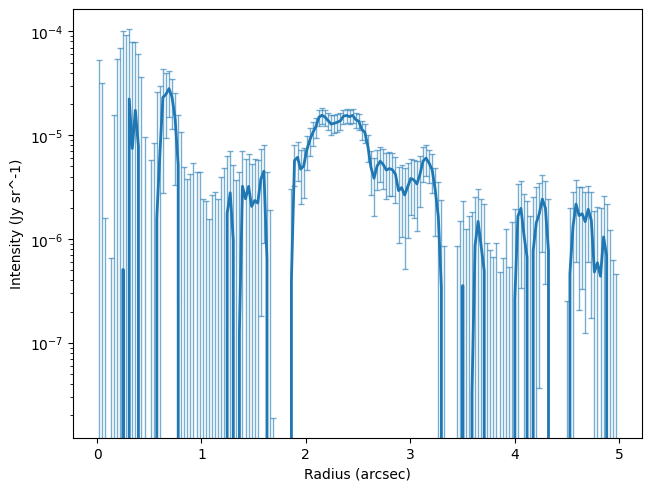

In [32]:
# A simple example plot of the nonaxisymmetric residuals for disk AA_Tau with robust value 0.5
# Adapting from section 4.2 of the exoALMA X paper


cube = all_disks["AA_Tau"].get_cube("1.0", cube_type="residual")
#cube = imagecube('D:\exoALMA_disk_data\AA_Tau\images_frank_residuals_different_robust\AA_Tau_continuum_resid_robust0.5.image.fits', FOV=10.0)

x, y, dy = cube.radial_profile(inc=all_disks["AA_Tau"].inc, PA=all_disks["AA_Tau"].PA)

fig, ax = plt.subplots(constrained_layout=True)
# Plot the main line with a thicker width
ax.plot(x, y, color='C0', linewidth=2, label='Profile')
# Overlay lighter error bars
ax.errorbar(x, y, dy, fmt='none', ecolor='C0', alpha=0.6, elinewidth=1, capsize=2, label='Uncertainty')
ax.set_yscale('log')
ax.set_xlabel('Radius (arcsec)')  # nope, please be in au
ax.set_ylabel('Intensity (Jy sr^-1)')



# First , plot the full disk profile -> change the axes labels and calculations -> load the residuals 


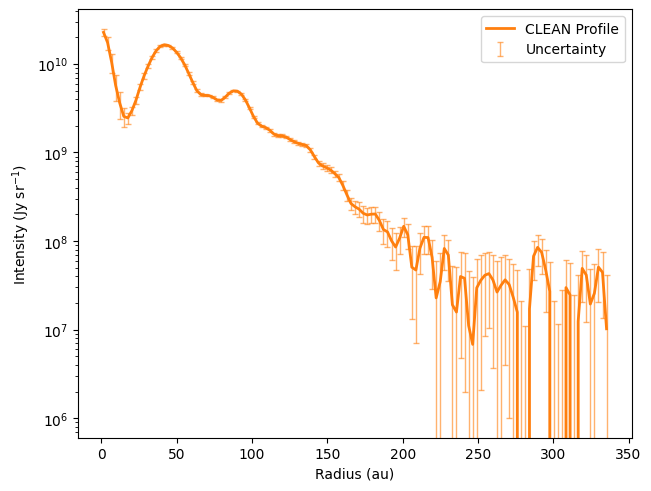

In [33]:
# plot full radial profile for disk AA_Tau with robust value 0.5

disk = all_disks["AA_Tau"]
r = disk.clean_profile["radius_au"]
I = disk.clean_profile["intensity_Jy_sr"]
dI = disk.clean_profile["d_intensity_Jy_sr"]

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(r, I, color='C1', linewidth=2, label='CLEAN Profile')
ax.errorbar(r, I, dI, fmt='none', ecolor='C1', alpha=0.6, elinewidth=1, capsize=2, label='Uncertainty')
ax.set_yscale('log')
ax.set_xlabel('Radius (au)')
ax.set_ylabel('Intensity (Jy sr$^{-1}$)')
ax.legend()
plt.show()

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0, 0.5, 'Intensity (Jy sr^-1)')

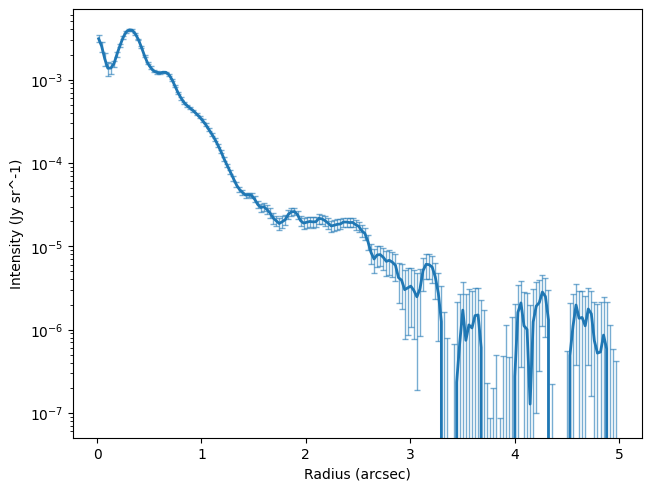

In [ ]:
cube_cl = all_disks["AA_Tau"].get_cube("1.0", cube_type="clean")

x, y, dy = cube_cl.radial_profile(inc=all_disks["AA_Tau"].inc, PA=all_disks["AA_Tau"].PA)

fig, ax = plt.subplots(constrained_layout=True)
# Plot the main line with a thicker width
ax.plot(x, y, color='C0', linewidth=2, label='Profile')
# Overlay lighter error bars
ax.errorbar(x, y, dy, fmt='none', ecolor='C0', alpha=0.6, elinewidth=1, capsize=2, label='Uncertainty')
ax.set_yscale('log')
ax.set_xlabel('Radius (arcsec)')  # nope, please be in au
ax.set_ylabel('Intensity (Jy beam^-1)')
